# 케라스로 다층 퍼셉트론 구현하기

케라스는 모든 종류의 신경망을 손쉽게 만들고 훈련, 평가, 실행할 수 있는 고수준 딥러닝 API임.

API document는 https://keras.io 에 있음. 

다양한 참조 구현이 존재하지만 이 책에서는 tf.keras를 이용함.

파이토치(https://pytorch.org)도 인기있는 딥러닝 라이브러리의 일종이고, 이 API는 케라스와 매우 유사함.
- 두 API 모두 사이킷런과 체이너(https://chainer.org)에서 부분적으로 영감을 얻었음.



In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

## 텐서플로 버전 확인

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
keras.__version__

'2.6.0'

In [4]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

tensorflow version :  2.6.0
keras version :  2.6.0


## 시퀀셜 API를 이용해서 이미지 분류기 만들기

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
print(X_train_full.shape)
print(X_train_full.dtype)

(60000, 28, 28)
uint8


케라스를 사용하여 MNIST 데이터셋을 적재할 때 사이킷런과의 차이점은 각 이미지가 784크기의 1D 배열이 아닌 (28, 28)의 배열이라는 점임. 

또한 픽셀 강도가 실수형이 아니라 정수형으로 되어 있음.

이미지셋이 이미 훈련 세트와 테스트 세트로 나눠져있기 때문에 검증 세트만 만들어주면 됨.

또한 경사하강법으로 신경망을 훈련하기 때문에 스케일을 조정해줘야 함. 
- 픽셀 강도를 255로 나누어 0~1로 스케일링 하면 됨 

In [7]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:] 
X_test = X_test / 255.0

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class : Coat


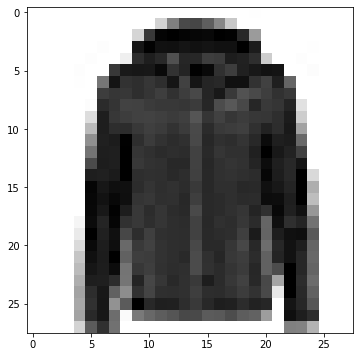

In [9]:
print(f'class : {class_names[y_train[0]]}')
plt.figure(figsize = (6, 6))
plt.imshow(X_train[0], cmap = 'gray_r')
plt.show()

**시퀀셜 API를 이용해 모델 만들기**
두 개의 은닉층으로 이루어진 분류용 다층 퍼셉트론 생성

```python
# Sequential 모델 생성
model = keras.models.Sequential()

# 첫 번째 층을 만들고 모델에 생성 (입력 이미지를 1D로 변환)
model.add(keras.layers.Flatten(input_shape = [28, 28]))

# 뉴런을 300개 가진 Dense 은닉층 추가
model.add(keras.layers.Dense(300, activation = 'relu'))


# 뉴런을 100개 가진 Dense 은닉층 추가
model.add(keras.layers.Dense(100, activation = 'relu'))

# 뉴런을 10개(클래스의 수) 가진 Dense 출력층 추가
# 배타적인 클래스이기 때문에 소프트맥스 활성화 함수를 사용
model.add(keras.layers.Dense(10, activation = 'softmax'))
```

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

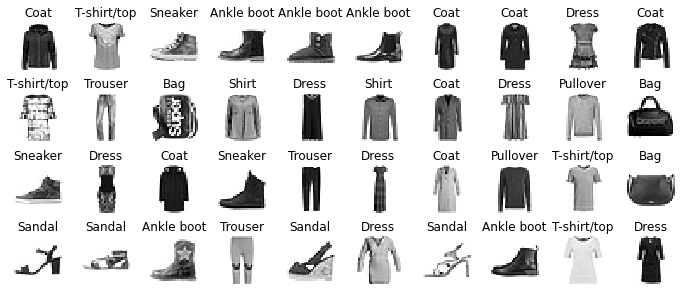

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

층을 하나씩 추가하지 않고 Sequential 모델을 만들 때 층의 리스트를 전달하는 방식으로 모델을 생성할 수 있음.

In [12]:
# Sequential 모델 생성
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Dense 층은 많은 파라미터를 가진다. 학습하기 충분한 유연성을 가지지만 반대로 과대적합의 위험도 존재한다.
> 이 문제에 대해서는 나중에 고려

모델에 있는 층의 리스트를 출력하거나 인덱스로 층을 선택할 수 있고, 이름으로도 선택할 수 있다.

In [14]:
model.layers

In [15]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [16]:
model.get_layer(hidden1.name) is hidden1

True

층의 파라미터는 get_weights() 메서드와 set_weights() 메서드를 사용해서 접근할 수 있다. Dense층의 경우 연결 가중치와 편향이 모두 포함되어 있다.

In [17]:
weights, bias = hidden1.get_weights()

In [18]:
print(weights.shape)
print(weights)

(784, 300)
[[ 0.04360454  0.01617707 -0.06270931 ...  0.00788605  0.05956057
   0.00241943]
 [ 0.04076345  0.0612286   0.06322175 ...  0.0033657  -0.04981204
  -0.02285985]
 [ 0.04305305  0.01606725  0.06731656 ... -0.05209358 -0.03413086
   0.02172706]
 ...
 [-0.03189527  0.05504732  0.03009623 ...  0.03771348  0.0077345
   0.03515758]
 [ 0.05257106 -0.03209358 -0.02268842 ...  0.03153296 -0.04805424
  -0.03425997]
 [-0.04700671 -0.05082727  0.06530562 ... -0.0089292  -0.02158074
   0.02416912]]


In [19]:
print(bias.shape)
print(bias)

(300,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Dense 층에서는 가중치가 무작위로 초기화된다(대칭성을 깨뜨리기 위해).

Bias는 0으로 초기화된다.
- 다른 초기화 방법도 존재하지만 나중에 고려함

**모델 컴파일**
모델을 생성한 후에 compile() 메서드를 호출하여 사용할 손실 함수와 옵티마이저를 지정해야 한다.
부가적으로 훈련과 평가 시에 계산할 지표를 추가로 지정할 수 있다. 

In [20]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'sgd', 
              metrics = ['accuracy'])

레이블이 하나의 정수로 이루어져있고 클래스가 배타적이기 때문에 **sparse_categorical_crossentropy**를 사용한다. 

만약 샘플별로 각 클래스 별 확률을 가지고 있다면 (예를 들어 클래스 3인 경우 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]인 원-핫 벡터라면) **categorical_crossentropy**를 사용한다. 

이진 분류를 사용한다면 출력층에 **softmax** 대신 **sigmoid** 함수를 사용하고 **binary_crossentropy** 손실을 사용한다.

SGD 옵티마이저를 사용할 때 학습률을 튜닝하는 것이 중요하다. 보통 

```{python}
optimizer = keras.optimizers.SGD(lr = ??)
```
와 같이 사용한다. 

```{python}
optimizer = 'sgd'
```
의 경우 기본값인 lr = 0.01을 사용한다.

**모델 훈련과 평가**

In [21]:
history = model.fit(X_train, y_train, epochs = 30, 
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7134 - accuracy: 0.7650 - val_loss: 0.5183 - val_accuracy: 0.8280
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4891 - accuracy: 0.8285 - val_loss: 0.4494 - val_accuracy: 0.8456
Epoch 3/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4441 - accuracy: 0.8443 - val_loss: 0.4727 - val_accuracy: 0.8372
Epoch 4/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4191 - accuracy: 0.8530 - val_loss: 0.4286 - val_accuracy: 0.8514
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3989 - accuracy: 0.8602 - val_loss: 0.3792 - val_accuracy: 0.8674
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3821 - accuracy: 0.8646 - val_loss: 0.3720 - val_accuracy: 0.8740
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3675 - accuracy: 0.8692 - val_loss: 0.4073 - val_accuracy:

In [22]:
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


훈련 데이터와 검증 데이터의 정확도의 차이가 크지 않기 때문에 과대적합이 일어나지 않은 것으로 판단된다.

클래스별 비율이 차이나는 경우 fit() 메서드를 호출할 때 class_weight 매개변수를 지정하는 것이 좋다. 
- 적게 등장하는 클래스에는 높은 가중치, 많이 등장하는 클래스에는 낮은 가중치를 부여

fit() 메서드가 반환하는 History 객체에는 훈련 파라미터(history.params), 수행된 에포크 리스트(history.epoch)가 포함된다. 이 객체의 가장 중요한 속성은 에포크가 끝날 때마다 훈련 세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리이다.(history.history)
- 이 딕셔너리를 이용해 판다스 데이터프레임을 만들고 plot() 메서드를 호출하면 learning curve를 볼 수 있다.

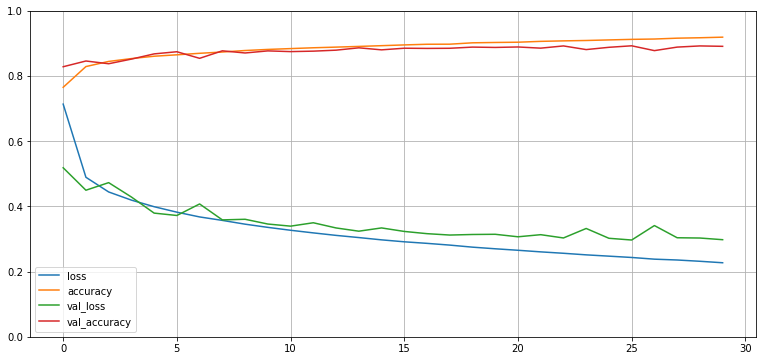

In [23]:
import pandas as pd 
import matplotlib.pyplot as plt 
pd.DataFrame(history.history).plot(figsize = (13, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

검증 손실이 계속해서 감소하고 있다는 것은 아직 모델이 완전히 수렴되지 않았다는 의미로 볼 수 있다.
- 훈련을 더 진행할 필요가 있음
- 이 경우 fit() 메서드를 다시 호출하면 중지되었던 곳에서 이어서 학습을 진행한다.

In [24]:
history = model.fit(X_train, y_train, epochs = 30, 
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2240 - accuracy: 0.9191 - val_loss: 0.3012 - val_accuracy: 0.8896
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2199 - accuracy: 0.9208 - val_loss: 0.3093 - val_accuracy: 0.8886
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2162 - accuracy: 0.9228 - val_loss: 0.3387 - val_accuracy: 0.8828
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2122 - accuracy: 0.9225 - val_loss: 0.3002 - val_accuracy: 0.8904
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2087 - accuracy: 0.9246 - val_loss: 0.3071 - val_accuracy: 0.8856
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2067 - accuracy: 0.9255 - val_loss: 0.2900 - val_accuracy: 0.8942
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2026 - accuracy: 0.9287 - val_loss: 0.3060 - val_accuracy:

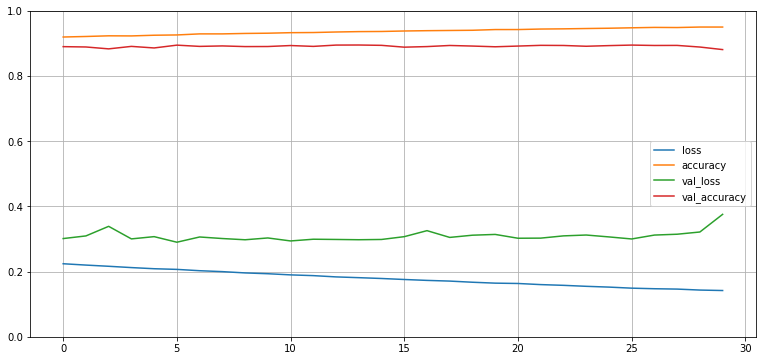

In [25]:
pd.DataFrame(history.history).plot(figsize = (13, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

모델 성능이 만족스럽지 않은 경우 하이퍼파라미터를 튜닝해야 한다.
- 첫 번째로 학습률을 확인해야 한다. 
- 학습률이 도움이 되지 않는 경우 다른 옵티마이저를 테스트해보는 것이 좋다. 
    - 항상 다른 하이퍼 파라미터를 튜닝하고 나서는 학습률을 다시 튜닝해야 한다.
- 여전히 성능이 만족스럽지 않으면 층 개수, 층에 있는 뉴런 개수, 은닉층이 사용하는 활성화 함수와 같은 모델의 하이퍼 파라미터를 튜닝한다. 배치 크기와 같이 다른 하이퍼 파라미터를 튜닝할 수도 있다.
- 성능이 만족스럽다면 상용 환경으로 배포하기 전에 테스트 세트로 모델을 평가하여 일반화 오차를 추정해야 한다. 이 때 evaluate() 메서드를 사용한다. 

In [26]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 927us/step - loss: 0.4058 - accuracy: 0.8708


[0.4057953953742981, 0.8708000183105469]

**모델을 사용해서 예측 만들기**

In [27]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [28]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [29]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [30]:
class_names[y_test[0]]

'Ankle boot'

Text(0.5, 1.0, 'Trouser')

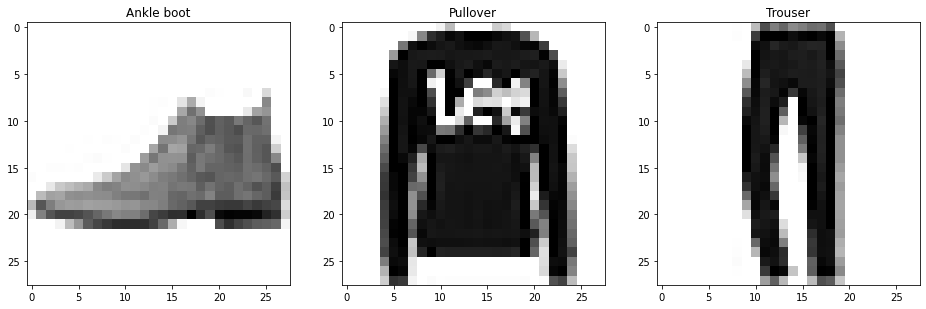

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
ax[0].imshow(X_test[0], cmap = 'gray_r')
ax[0].set_title(class_names[y_test[0]])
ax[1].imshow(X_test[1], cmap = 'gray_r')
ax[1].set_title(class_names[y_test[1]])
ax[2].imshow(X_test[2], cmap = 'gray_r')
ax[2].set_title(class_names[y_test[2]])

## 시퀀셜 API를 이용해서 회귀용 다층 퍼셉트론 만들기

In [32]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

회귀용 MLP을 구축, 훈련, 평가, 예측하는 과정은 분류에서 했던 것과 매우 비슷하다.

주된 차이점은 출력층이 활성화 함수가 없는 하나의 뉴런을 가진다는 것과 손실 함수로 평균 제곱 오차를 사용한다는 것이다. 

노이즈가 많은 데이터셋이기 때문에 과대적합을 막는 용도로 뉴런 수가 적은 은닉층 하나만을 사용한다.

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_squared_error', optimizer = 'sgd')
history = model.fit(X_train, y_train, epochs = 20, 
                    validation_data = (X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 793us/step - loss: 0.7294 - val_loss: 15.9921
Epoch 2/20
363/363 [==============================] - 0s 642us/step - loss: 0.6180 - val_loss: 9.6009
Epoch 3/20
363/363 [==============================] - 0s 677us/step - loss: 0.5292 - val_loss: 0.4534
Epoch 4/20
363/363 [==============================] - 0s 686us/step - loss: 0.3957 - val_loss: 0.3639
Epoch 5/20
363/363 [==============================] - 0s 719us/step - loss: 0.3849 - val_loss: 0.3605
Epoch 6/20
363/363 [==============================] - 0s 660us/step - loss: 0.3776 - val_loss: 0.3825
Epoch 7/20
363/363 [==============================] - 0s 694us/step - loss: 0.3765 - val_loss: 0.3767
Epoch 8/20
363/363 [==============================] - 0s 791us/step - loss: 0.3689 - val_loss: 0.3864
Epoch 9/20
363/363 [==============================] - 0s 809us/step - loss: 0.3649 - val_loss: 0.4068
Epoch 10/20
363/363 [==============================] - 0s 669us/step - loss: 0.36

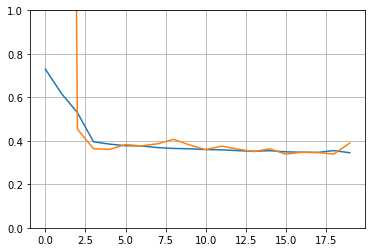

In [35]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

입력과 출력이 여러 개거나 더 복잡한 네트워크 토폴로지를 갖는 신경망을 만들어야 하는 경우가 있다.
> 케라스는 함수형 API를 제공 

## 함수형 API를 사용해 복잡한 모델 만들기

순차적이지 않은 신경망의 한 예는 와이드&딥 신경망이다. 
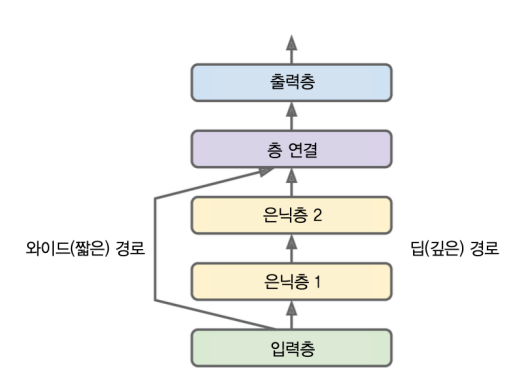
이 신경망은 입력층의 일부 또는 전체가 출력층으로 바로 연결되는 구조를 갖는다.

이 구조를 사용하면 복잡한 패턴과 간단한 규칙을 모두 학습할 수 있다. 이와는 대조적으로 MLP는 모든 층에 데이터를 통과시키기 때문에 간단한 패턴이 연속된 변환으로 인해 왜곡될 수 있다.

In [36]:
# Input 객체 생성
input_ = keras.layers.Input(shape = X_train.shape[1:])

# Dense층 생성, 생성하자마자 입력과 함께 함수처럼 호출됨
hidden1 = keras.layers.Dense(30, activation = 'relu')(input_)

# 두 번째 은닉층을 만들고 함수처럼 호출한다. 첫 번째 층의 출력을 전달했음
hidden2 = keras.layers.Dense(30, activation = 'relu')(hidden1)

# Concatenate층을 만들고 또 다시 함수처럼 연결하여 두 번째 은닉층의 출력과 입력을 연결함
concat = keras.layers.Concatenate()([input_, hidden2])

# 하나의 뉴런과 활성화 함수가 없는 출력층을 만들고 Concatenate층이 만든 결과를 사용해 호출
output = keras.layers.Dense(1)(concat)

# 사용할 입력과 출력을 지정하여 Model 생성
model = keras.Model(inputs = [input_], outputs = [output])

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [38]:
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.8772 - val_loss: 0.6913
Epoch 2/20
363/363 [==============================] - 0s 911us/step - loss: 0.6501 - val_loss: 0.9454
Epoch 3/20
363/363 [==============================] - 0s 661us/step - loss: 0.6012 - val_loss: 0.6622
Epoch 4/20
363/363 [==============================] - 0s 716us/step - loss: 0.5654 - val_loss: 0.5284
Epoch 5/20
363/363 [==============================] - 0s 764us/step - loss: 0.5414 - val_loss: 0.5004
Epoch 6/20
363/363 [==============================] - 0s 663us/step - loss: 0.5181 - val_loss: 0.5894
Epoch 7/20
363/363 [==============================] - 0s 752us/step - loss: 0.5035 - val_loss: 0.5889
Epoch 8/20
363/363 [==============================] - 0s 707us/step - loss: 0.4904 - val_loss: 0.4690
Epoch 9/20
363/363 [==============================] - 0s 856us/step - loss: 0.4769 - val_loss: 0.5305
Epoch 10/20
363/363 [==============================] - 0s 887us/step - loss: 0.4676 

일부 특성은 짧은 경로로, 일부 특성은 깊은 경로로 전달하고 싶으면(중복도 허용해서) 가능한 한 가지 방법은 여러 입력을 사용하는 것이다. 예를 들어 5개(0\~4 인덱스)의 특성은 짧은 경로로 보내고 6개(2\~7 인덱스)의 특성은 깊은 경로로 보낸다고 가정해보자.

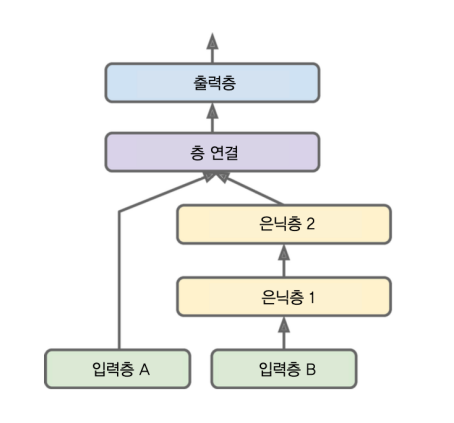

In [39]:
# Input A 객체 생성
input_A = keras.layers.Input(shape = [5], name = 'wide_input')

# Input B 객체 생성
input_B = keras.layers.Input(shape = [6], name = 'deep_input')

# Dense층 생성, 입력 B를 받게 됨
hidden1 = keras.layers.Dense(30, activation = 'relu')(input_B)

# Dense층 생성, 입력 B를 받은 은닉층1을 받게 됨
hidden2 = keras.layers.Dense(30, activation = 'relu')(hidden1)

# Concatenate층 생성, 입력층 A와 입력 B, 은닉층 1을 받은 은닉층2를 받게 됨
concat = keras.layers.Concatenate()([input_A, hidden2])

# 하나의 뉴런과 활성화 함수가 없는 출력층을 만들고 Concatenate층이 만든 결과를 사용해 호출
output = keras.layers.Dense(1, name = 'output')(concat)

# 사용할 입력과 출력을 지정하여 Model 생성
model = keras.Model(inputs = [input_A, input_B], outputs = [output])

모델을 컴파일할 때 입력 행렬 하나를 전달하는 것이 아니라 입력마다 하나씩 행렬의 튜플(X_train_A, X_train_B)를 전달해야 한다. 

이는 X_valid에도 동일하게 적용되고, evaluate()나 predict()를 호출할 때 X_test에도 동일하게 적용된다.

In [40]:
model.compile(loss = 'mse', optimizer = keras.optimizers.SGD(lr = 1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs = 20,
                    validation_data = ((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
363/363 [==============================] - 1s 969us/step - loss: 2.0090 - val_loss: 0.9850
Epoch 2/20
363/363 [==============================] - 0s 799us/step - loss: 0.7896 - val_loss: 0.7180
Epoch 3/20
363/363 [==============================] - 0s 744us/step - loss: 0.6514 - val_loss: 0.6402
Epoch 4/20
363/363 [==============================] - 0s 901us/step - loss: 0.5991 - val_loss: 0.5778
Epoch 5/20
363/363 [==============================] - 0s 796us/step - loss: 0.5671 - val_loss: 0.5449
Epoch 6/20
363/363 [==============================] - 0s 956us/step - loss: 0.5423 - val_loss: 0.5190
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5228 - val_loss: 0.5011
Epoch 8/20
363/363 [==============================] - 0s 774us/step - loss: 0.5073 - val_loss: 0.4808
Epoch 9/20
363/363 [==============================] - 0s 686us/step - loss: 0.4945 - val_loss: 0.4661
Epoch 10/20
363/363 [==============================] - 0s 824us/step - loss: 0.4841 

**여러 개의 출력이 필요한 경우?**
- 여러 출력이 필요한 작업 
    - 예를 들어 그림에 있는 주요 물체를 파악하고 위치를 알아야 할 수가 있다. 회귀 작업(물체 중심의 좌표와 너비, 높이 탐색)과 분류 작업을 함께 하는 경우

- 동일한 데이터에서 독립적인 작업을 수행하는 경우 
    - 작업마다 새로운 신경망을 훈련할 수 있지만 작업마다 하나의 출력을 가진 단일 신경망을 훈련하는 것이 보통 더 나은 결과를 낸다. 신경망이 여러 작업에 걸쳐 유용한 특성을 학습할 수 있기 때문이다. 
    - 예를 들어 얼굴 사진으로 다중 분류를 수행하는 경우
        - 한 출력은 사람의 얼굴 표정을 분류
        - 다른 한 출력은 안경 유무를 분류
- 규제 기법으로 사용하는 경우(과대적합 방지)
    - 신경망 구조 안에 보조 출력을 추가할 수 있다. 보조 출력을 이용해 하위 네트워크가 나머지 네트워크에 의존하지 않고 그 자체로 유용한 것을 학습하는지 확인할 수 있다.

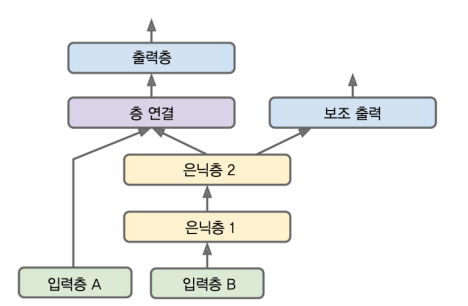

보조 출력 추가하기

In [41]:
# Input A 객체 생성
input_A = keras.layers.Input(shape = [5], name = 'wide_input')

# Input B 객체 생성
input_B = keras.layers.Input(shape = [6], name = 'deep_input')

# Dense층 생성, 입력 B를 받게 됨
hidden1 = keras.layers.Dense(30, activation = 'relu')(input_B)

# Dense층 생성, 입력 B를 받은 은닉층1을 받게 됨
hidden2 = keras.layers.Dense(30, activation = 'relu')(hidden1)

# Concatenate층 생성, 입력층 A와 입력 B, 은닉층 1을 받은 은닉층2를 받게 됨
concat = keras.layers.Concatenate()([input_A, hidden2])

# 하나의 뉴런과 활성화 함수가 없는 출력층을 만들고 Concatenate층이 만든 결과를 사용해 호출
output = keras.layers.Dense(1, name = 'output')(concat)

# 보조출력 추가
aux_output = keras.layers.Dense(1, name = 'aux_output')(hidden2)

# 사용할 입력과 출력을 지정하여 Model 생성
model = keras.Model(inputs = [input_A, input_B], outputs = [output, aux_output])

각 출력은 자신만의 손실 함수가 필요하다. 기본적으로 케라스는 나열된 손실을 모두 더하여 최종 손실을 계산한다. 보조 출력은 규제로만 사용되기 때문에 주 출력의 손실에 더 많은 가중치를 부여해야 한다.

In [42]:
model.compile(loss = ['mse', 'mse'], loss_weights = [0.9, 0.1], optimizer = 'sgd')

각 출력에 대한 레이블 제공해야 한다. 여기서는 주 출력과 보조 출력이 같은 것을 예측해야 하기 때문에 동일한 레이블을 사용한다. 

In [43]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs = 20,
    validation_data = ([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9014 - output_loss: 0.7646 - aux_output_loss: 2.1322 - val_loss: 2.2432 - val_output_loss: 2.3473 - val_aux_output_loss: 1.3063
Epoch 2/20
363/363 [==============================] - 0s 912us/step - loss: 0.5549 - output_loss: 0.4924 - aux_output_loss: 1.1172 - val_loss: 7.4504 - val_output_loss: 8.1643 - val_aux_output_loss: 1.0256
Epoch 3/20
363/363 [==============================] - 0s 937us/step - loss: 0.5726 - output_loss: 0.5261 - aux_output_loss: 0.9914 - val_loss: 0.5967 - val_output_loss: 0.4033 - val_aux_output_loss: 2.3374
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4770 - output_loss: 0.4327 - aux_output_loss: 0.8757 - val_loss: 0.5180 - val_output_loss: 0.4091 - val_aux_output_loss: 1.4986
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4595 - output_loss: 0.4236 - aux_output_loss: 0.7825 - val_loss: 0.4813 - val_output_loss: 0.4108 - val_

In [44]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(y_pred_main)
print(y_pred_aux)

162/162 [==============================] - 0s 768us/step - loss: 0.3673 - output_loss: 0.3545 - aux_output_loss: 0.4831
[[0.57737625]
 [1.660349  ]
 [3.465272  ]]
[[0.96942735]
 [1.9277482 ]
 [2.9906895 ]]


## 서브클래싱 API로 동적 모델 만들기

시퀀셜 API와 함수형 API는 모두 선언적이다.
- 사용할 층과 연결 방식을 먼저 정의해야 함
- 그 후에 모델에 데이터를 주입하여 훈련이나 추론을 시작할 수 있다.
- 모델을 저장하거나 복사, 공유하기 쉽다는 장점이 있다. 또한 모델의 구조를 출력하거나 분석하기 좋다
- 프레임워크가 크기를 짐작하고 타입을 확인하여 에러를 일찍 발견할 수 있다는 장점이 있다.
- 전체 모델이 층으로 구성된 정적 그래프이므로 디버깅하기도 쉽다.
    - 어떤 모델은 반복문을 포함하고 다양한 크기를 다루어야 하며 조건문을 가지는 등 여러 동적인 구조를 필요로 한다는 점에서 정적이라는 것이 단점으로 작용할 수도 있다.

> 이런 경우에 조금 더 명령형 프로그래밍 스타일이 필요하다면 서브클래싱 API가 정답일 수 있다.

1. Model 클래스를 상속한 다음 생성자 안에서 필요한 층을 만든다. 
2. 그 다음 call() 메서드 안에 수행하려는 연산을 기술한다.
    - 예를 들어 WideAndDeepModel 클래스의 인스턴스는 앞서 함수형 API로 만든 모델과 동일한 기능을 수행한다.


In [47]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [48]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.4779 - output_1_loss: 2.2495 - output_2_loss: 4.5334 - val_loss: 2.3091 - val_output_1_loss: 2.1650 - val_output_2_loss: 3.6064
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 1.0367 - output_1_loss: 0.8524 - output_2_loss: 2.6948 - val_loss: 1.1543 - val_output_1_loss: 0.9436 - val_output_2_loss: 3.0508
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.8111 - output_1_loss: 0.6882 - output_2_loss: 1.9164 - val_loss: 0.8972 - val_output_1_loss: 0.6708 - val_output_2_loss: 2.9343
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7203 - output_1_loss: 0.6216 - output_2_loss: 1.6083 - val_loss: 0.8175 - val_output_1_loss: 0.5908 - val_output_2_loss: 2.8576
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6718 - output_1_loss: 0.5819 - output_2_loss: 1.4805 - val_loss: 0.7650 - val_output_1_loss: 0.5440 - val_ou

## 모델 저장과 복원 

시퀀셜 API와 함수형 API를 사용하면 훈련된 케라스 모델을 저장하는 것은 다음과 같이 매우 쉬워진다.

```python
model = keras.models.Sequential([...])
model.compile([...])
model.fit([...])
model.save('my_keras_model.h5')
```


케라스는 HDF5 포맷을 사용하여 모델 구조와 층의 모든 모델 파라미터(연결 가중치, 편향)을 저장한다. 또한 옵티마이저도 저장한다. 

일반적으로 하나의 파이썬 스크립트에서 모델을 훈련하고 저장한 다음 하나 이상의 스크립트 또는 웹 서비스에서 모델을 로드하고 예측을 만드는 데 사용한다. 모델 로드는 다음과 같이 간단하다.

```{python}
model = keras.models.load_model('my_keras_model.h5')
```

훈련이 몇 시간동안 저장되는 경우는 중간에 문제가 생겨서 훈련이 중단되면 모든 정보가 사라진다. 이를 방지하기 위해 훈련 도중 일정 간격으로 체크포인트를 저장해야 한다. 

> 콜백을 사용하면 fit() 메서드에서 체크포인트를 생성할 수 있다.

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [51]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 962us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 672us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 730us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 776us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 685us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 657us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 849us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 696us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 876us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 601us/step - loss: 0.438

In [52]:
model.save("my_keras_model.h5")

In [53]:
model = keras.models.load_model("my_keras_model.h5")

In [54]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [55]:
model.save_weights("my_keras_weights.ckpt")

In [56]:
model.load_weights("my_keras_weights.ckpt")

## 콜백 사용하기

에포크의 시작이나 끝, 각 배치 처리 전후에 호출할 수 있다.

예를 들어 ModelCheckpoint는 훈련하는 동안 일정한 간격으로 체크포인트를 저장한다. 기본적으로 매 에포크의 끝에서 호출된다.

```python
checkpoint_cn = keras.callbacks.ModelCheckpoint('my_keras_model.h5')
history = model.fit(X_train, y_train, epochs = 10, callbacks = [checkpoint_ch])
```

훈련하는 동안 검증 세트를 사용하면 ModelCheckpoint를 만들 때 save_best_only = True로 지정할 수 있다. 최상의 검증 세트 점수에서만 모델을 저장하기 때문에 과대적합의 걱정이 없다. 

조기 종료를 구현한 코드

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

model.compile(loss="mse", optimizer = keras.optimizers.SGD(learning_rate = 1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs = 10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 818us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 638us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 700us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 711us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 818us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 727us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 799us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 652us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 707us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 571us/step - loss: 0.438

조기 종료를 구현하는 또 다른 방법은 EarlyStopping 콜백을 사용하는 것이다.

일정 에포크동안 검증 세트에 대한 점수가 향상되지 않으면 훈련을 멈춘다.

체크 포인트 저장 콜백과 진전이 없는 경우 훈련을 멈추는 콜백을 함께 사용할 수 있다.

In [59]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 893us/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 747us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 755us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 762us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 755us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 738us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 690us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - ETA: 0s - loss: 0.401 - 0s 769us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 692us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [===========================

Epoch 80/100
363/363 [==============================] - 0s 661us/step - loss: 0.3329 - val_loss: 0.3353
Epoch 81/100
363/363 [==============================] - 0s 658us/step - loss: 0.3324 - val_loss: 0.3276
Epoch 82/100
363/363 [==============================] - 0s 653us/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 0s 773us/step - loss: 0.3317 - val_loss: 0.3281
Epoch 84/100
363/363 [==============================] - 0s 728us/step - loss: 0.3312 - val_loss: 0.3636
Epoch 85/100
363/363 [==============================] - 0s 714us/step - loss: 0.3310 - val_loss: 0.3175
Epoch 86/100
363/363 [==============================] - 0s 796us/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 0s 806us/step - loss: 0.3305 - val_loss: 0.3532
Epoch 88/100
363/363 [==============================] - 0s 873us/step - loss: 0.3299 - val_loss: 0.3256
Epoch 89/100
363/363 [==============================] - 0s 777us

In [60]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [61]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 884us/step - loss: 0.3302 - val_loss: 0.3559

val/train: 1.08


## 텐서보드를 활용해서 시각화하기

텐서보드를 사용하려면 프로그램을 수정하여 이벤트 파일이라는 특별한 이진 로그 파일에 시각화하려는 데이터를 출력해야 한다. 각각의 이진 데이터 레코드를 summary라고 한다. 

텐서보드 서버는 로그 디렉토리를 모니터링하고 자동으로 변경사항을 읽어 그래프를 업데이트한다. 

훈련하는 중간에 실시간으로 시각화할 수 있다.

일반적으로 텐서보드 서버가 루트 로그 디렉토리를 가리키고 프로그램을 실행할 때마다 다른 서브디렉토리에 이벤트를 기록한다. 이렇게 하면 복잡하지 않게 하나의 텐서보드 서버가 여러 번 실행한 프로그램의 결과를 시각화하고 비교할 수 있다.

텐서보드 로그를 위해 사용할 루트 로그 디렉토리를 정의
- 현재 날짜와 시간을 이용해 실행할 때마다 다른 서브디렉토리 경로를 생성하는 함수도 생성
- 테스트하는 하이퍼파라미터값과 같은 정보를 로그 디렉토리 이름으로 지정할 수 있다.

In [62]:
import os 
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_07_19-18_38_34'

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_squared_error', optimizer = 'sgd')

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs = 30, 
                    validation_data = (X_valid, y_valid),
                    callbacks = [tensorboard_cb])

In [63]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [65]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 641us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 686us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 758us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 680us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 720us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - ETA: 0s - loss: 0.484 - 0s 758us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 988us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 987u

In [73]:
!kill 16836

kill: 16836: No such process


In [74]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [75]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_07_19-18_45_32'

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [78]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5530 - val_loss: 302.8466
Epoch 2/30
363/363 [==============================] - 0s 731us/step - loss: 63.6669 - val_loss: 0.9735
Epoch 3/30
363/363 [==============================] - 0s 831us/step - loss: 0.9411 - val_loss: 0.9599
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9197 - val_loss: 0.8464
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9819 - val_loss: 0.9281
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9240 - val_loss: 0.9089
Epoch 7/30
363/363 [==============================] - 0s 751us/step - loss: 0.9179 - val_loss: 0.8815
Epoch 8/30
363/363 [==============================] - 0s 747us/step - loss: 0.8950 - val_loss: 0.9007
Epoch 9/30
363/363 [==============================] - 0s 788us/step - loss: 0.9150 - val_loss: 0.8734
Epoch 10/30
363/363 [==============================] - 0s 767us/step - loss: 0.8921 - v

# 신경망 하이퍼 파라미터 튜닝

첫 번째 방법은 GridSearchCV나 RandomizedSearchCV를 통해 하이퍼 파라미터 공간을 탐색하는 것이다. 

이렇게 하려면 케라스 모델을 사이킷런 추정기처럼 보이도록 바꿔야 한다. 

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape = [8]) : 
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden) : 
        model.add(keras.layers.Dense(n_neurons, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr = learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

In [81]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [82]:
keras_reg.fit(X_train, y_train, epochs = 100,
              validation_data = (X_valid, y_valid),
              callbacks = [keras.callbacks.EarlyStopping(patience = 10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

Epoch 1/100
363/363 [==============================] - 1s 888us/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 838us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 730us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 738us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 708us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 711us/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 688us/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 617us/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 612us/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 664us/step - 

In [84]:
y_pred = keras_reg.predict(X_new)
y_pred

array([0.6514432, 1.6107497, 4.071351 ], dtype=float32)

하나의 모델에 대한 훈련과 평가의 과정이 아니라 수백 개의 모델을 훈련하고 검증 세트에서 최상의 모델을 선택해야 한다. 하이퍼 파라미터가 많기 때문에 랜덤 서치가 좋다. 

In [ ]:
from scipy.stats import reciprocal 
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden' : [0, 1, 2, 3],
    'n_neurons' : np.arange(1, 100),
    'learning_rate' : reciprocal(3e-4, 3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter = 10, cv = 3)
rnd_search_cv.fit(X_train, y_train, epochs = 100,
              validation_data = (X_valid, y_valid),
              callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
model = rnd_search_cv.best_estimator_.model

## 은닉층 개수